<a href="https://colab.research.google.com/github/joaochenriques/IST_MCTE/blob/main/Barrages/PowerLimits/PowerLimits_2024_V02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as mpl
import os, pathlib
import scipy.integrate as integrate

if not pathlib.Path("mpl_utils.py").exists():
  os.system( "curl -O https://raw.githubusercontent.com/joaochenriques/ipynb_libs/main/mpl_utils.py" )
import mpl_utils as mut
mut.config_plots()

%config InlineBackend.figure_formats = ['svg']

In [2]:
from matplotlib.colors import LinearSegmentedColormap
color_list = ['#AAFFAA','#FFFFAA','#FFAAAA']
mycmap = LinearSegmentedColormap.from_list("",color_list)

In [3]:
π = np.pi
two_π = 2.0 * π
rpm2rads = π / 30.0

ρ = 1000.0
gr = 9.8
sqrt_gr = np.sqrt( gr )

## Single case with constant flow rate and constant basin area

In [4]:
T = 12.46 # hours
H = 5.0   # meter
EoS_max = 0.5 * ρ * gr * H**2

ω = two_π / T
A  = H / 2.0
t1 = 0.3 * T
t2 = 0.7 * T

QoS = A * ( 1.0 - np.cos( ω * t2 ) ) / ( t2- t1 )
QoS

0.6566096480612698

In [5]:
nn = 200
t_vec = np.linspace( t1, t2, nn )
Δt = t_vec[1] - t_vec[0]

z_vec = np.zeros( nn )

E_vec = np.zeros( nn )

z_vec[0] = A

In [6]:
for i in range( 1, nn ):
    z_vec[i] = z_vec[i-1] - Δt * QoS

    h = z_vec[i] - A * np.cos( ω * t_vec[i] )
    P = ρ * gr * h * QoS
    E_vec[i] = E_vec[i-1] + Δt * P

Eff = E_vec[-1] / EoS_max
Eff

0.7193173946417238

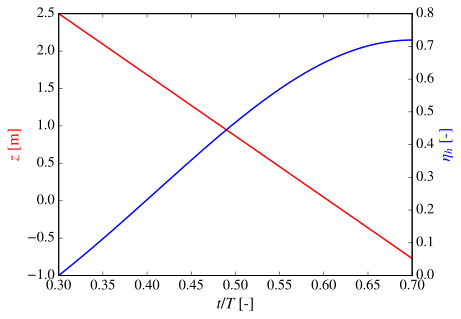

In [7]:
fig, ax1 = mpl.subplots()

ax2 = ax1.twinx()
ax1.plot( t_vec / T, z_vec, 'r' )
ax2.plot( t_vec / T, E_vec / EoS_max, 'b' )

ax1.set_xlabel('$t/T$ [-]')
ax1.set_ylabel('$z$ [m]', color='r')
ax2.set_ylabel('$\\eta_h$ [-]', color='b');

## Plot the map of all possible solutions for constant flow rate and constant basin area

In [8]:
def MeanEff_Const_QS( τ1, τ2 ):

    H = 2.0
    A = 1.0
    QoS = A * ( 1.0 - np.cos( two_π * τ2 ) ) / ( τ2 - τ1 )

    nn = 200

    τ_vec = np.linspace( τ1, τ2, nn )
    Δτ = τ_vec[1] - τ_vec[0]

    z_vec = np.zeros( nn )

    E_vec = np.zeros( nn )
    EoS_max = 0.5 * ρ * gr * H**2

    z_vec[0] = A
    for i in range( 1, nn ):
        z_vec[i] = z_vec[i-1] - Δτ * QoS

        h = z_vec[i] - A * np.cos( two_π * τ_vec[i] )
        P = ρ * gr * h * QoS
        E_vec[i] = E_vec[i-1] + Δτ * P

    Eff = E_vec[-1] / EoS_max
    return Eff

In [9]:
τ1_vec = np.linspace( 0.0, 0.4999, 100 )
τ2_vec = np.linspace( 0.5, 1.0, 100 )
T1, T2 = np.meshgrid( τ1_vec, τ2_vec )
ZE = np.zeros_like( T1 )
( ni, nj ) = T1.shape

for i in range( ni ):
    print( i%10, end='' )
    for j in range( nj):
        ZE[i,j] = MeanEff_Const_QS( T1[i,j], T2[i,j] ) * 100.0

0123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789

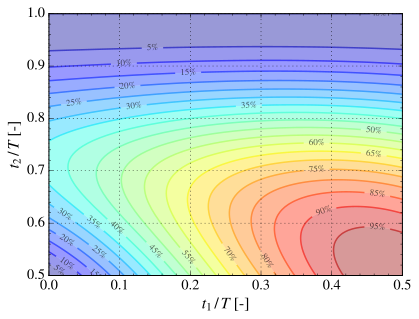

In [10]:
CS = mpl.contourf( T1, T2, ZE, 20, cmap = mpl.cm.jet, alpha = 0.4 )
CS = mpl.contour ( T1, T2, ZE, 20, alpha = 0.6 )
mpl.clabel( CS, CS.levels, fmt='$%.0f$%%', inline = True, fontsize=9, colors = 'k', rightside_up = True )
mpl.xlabel( r'$t_1\,/\,T$ [-]' )
mpl.ylabel( r'$t_2\,/\,T$ [-]' )
mpl.xlim( 0.0, 0.5 )
mpl.grid()
mpl.minorticks_on()
mpl.savefig('EnergyDeltaTau.pdf', bbox_inches='tight', pad_inches=0)

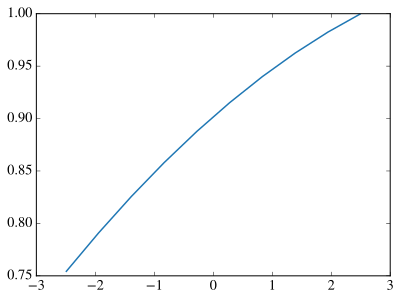

In [11]:
# coeffs of the quadratic polynomial that describes the basin area
# [ a, b, c ] => a*z**2 + b*z + c
basin_coeffs = np.array( [ -0.004418, 0.05461, 1.0 ] )

basin_Area = np.poly1d( basin_coeffs )
basin_dArea_dz = basin_Area.deriv(1)

y = np.linspace( -A, A, 10)
mpl.plot( y, basin_Area(y)/basin_Area(A) );

In [12]:
# Need to be intrgrated
EoS0_max = ρ * gr * ( basin_coeffs[0] * H**4 / 4.0 + basin_coeffs[1] * H**3 / 3.0 + basin_coeffs[2] * H**2 / 2.0 )

ω = two_π / T
A  = H / 2.0
Δt = 0.01

QoS0 = QoS

In [13]:
t_lst = [ t1 ]
z_lst = [ A ]
E_lst = [ 0.0 ]
S_lst = [ 1 ]

for i in range( 1, nn ):
    t_lst.append( t_lst[i-1] + Δt )

    S_im1 = basin_Area( z_lst[i-1] ) / basin_Area(A)
    dSdz_im1 = basin_dArea_dz( z_lst[i-1] ) / basin_Area(A)

    z_lst.append( z_lst[i-1] - Δt * QoS0 / ( z_lst[i-1]*dSdz_im1 + S_im1 ) )

    h = z_lst[i] - A * np.cos( ω * t_lst[i] )
    P = ρ * gr * h * QoS0
    E_lst.append( E_lst[i-1] + Δt * P )
    S_lst.append( S_im1 )

    if h <= 0.0: break

t_vec = np.array( t_lst )
z_vec = np.array( z_lst )
E_vec = np.array( E_lst )
S_vec = np.array( S_lst )

Eff = E_vec[-1] / EoS0_max
Eff

0.33644570430033316

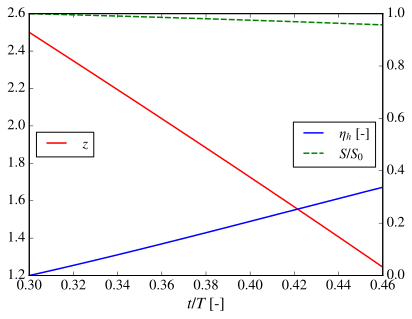

In [14]:
fig, ax1 = mpl.subplots()

ax2 = ax1.twinx()
ax1.plot( t_vec / T, z_vec, 'r', label='$z$' )
ax2.plot( t_vec / T, E_vec / EoS0_max, 'b', label='$\\eta_h$ [-]' )
ax2.plot( t_vec / T, S_vec, 'g', label='$S/S_0$' )
ax1.legend(loc='center left')
ax2.legend(loc='center right')

ax1.set_xlabel('$t/T$ [-]');

In [67]:
Tper = 12.42
Topen= 4.5
t1 = 1.0 - Topen/Tper
t2 = 1.0
A = (5.1+3.05)/2.0
Δt = t2 - t1
ΔZ = A - A * np.cos( 2 * np.pi * t2 )

func = lambda 𝜏: 1.0 / Δt * np.sqrt( 2.0 * gr * ( ( A - ΔZ / Δt * ( 𝜏 - t1) ) - A * np.cos( 2 * np.pi * 𝜏 ) ) )

integrate.quad( func, t1, t2)

(6.449264869656103, 7.160122350198364e-14)

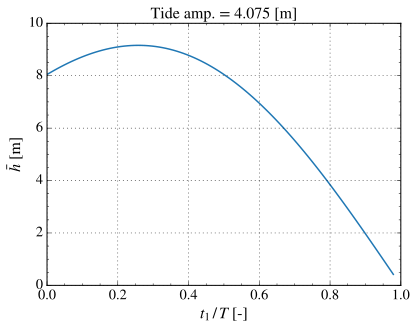

In [68]:
τ1_vec = np.linspace( 0.0, .98, 100 )
Ih = np.zeros_like( τ1_vec )

for i, t1 in enumerate( τ1_vec ):
    Δt = t2 - t1
    func = lambda 𝜏: 1.0 / Δt * np.sqrt( 2.0 * gr * ( ( A - ΔZ / Δt * ( 𝜏 - t1) ) - A * np.cos( 2 * np.pi * 𝜏 ) ) )
    Ih[i] = integrate.quad( func, t1, t2)[0]

mpl.title( f'Tide amp. = {A:.3f} [m]')
mpl.plot( τ1_vec, Ih )
mpl.xlabel( r'$t_1\,/\,T$ [-]' )
mpl.ylabel( r'$\bar{h}$ [m]' )
mpl.grid()
mpl.minorticks_on()
mpl.savefig('EnergyDeltaTau.pdf', bbox_inches='tight', pad_inches=0)